## Assignment 4

### Manual Value Iteration


$q_{1}(s_{1},a_{1}) = 8 + 0.2\cdot10+0.6\cdot1 = 10.6$

$q_{1}(s_{1},a_{2}) = 10 + 0.1\cdot10+0.2\cdot1 = 11.2$

$v_{1}(s_{1})=max(q_{1}(s_{1},a_{1}),q_{1}(s_{1},a_{2}))=max(10.6,11.2)=11.2$

$\pi_{1}(s_{1})=a_{2}$

$q_{1}(s_{2},a_{1}) = 1 + 0.3\cdot10+0.3\cdot1 = 4.3$

$q_{1}(s_{2},a_{2}) = -1 + 0.5\cdot10+0.3\cdot1 = 4.3$

$v_{1}(s_{2})=max(q_{1}(s_{1},a_{1}),q_{1}(s_{1},a_{2}))=max(4.3,4.3)=4.3$

$\pi_{1}(s_{2})=a_{1}(or \ a_{2})$

$q_{2}(s_{1},a_{1}) = 8 + 0.2\cdot11.2+0.6\cdot4.3 = 12.82$

$q_{2}(s_{1},a_{2}) = 10 + 0.1\cdot11.2+0.2\cdot4.3 = 11.98$

$v_{2}(s_{1})=max(q_{2}(s_{1},a_{1}),q_{2}(s_{1},a_{2}))=max(12.82,11.98)=12.82$

$\pi_{1}(s_{1})=a_{1}$

$q_{2}(s_{2},a_{1}) = 1 + 0.3\cdot11.2+0.3\cdot4.3 = 5.65$

$q_{2}(s_{2},a_{2}) = -1 + 0.5\cdot11.2+0.3\cdot4.3 = 5.89$

$v_{2}(s_{2})=max(q_{2}(s_{1},a_{1}),q_{2}(s_{1},a_{2}))=max(5.65,5.89)=5.89$

$\pi_{2}(s_{2})=a_{2}$

The difference between $q_{k}(s_{1},a_{1})$ and $q_{k}(s_{1},a_{2})$  
$q_{k}(s_{1},a_{2})-q_{k}(s_{1},a_{2})
=-2+0.1\cdot v_{k-1}(s_{1})+0.4\cdot v_{k-1}(s_{2})$  
For $k=3, \ 0.1\cdot v_{k-1}(s_{1})+0.4\cdot v_{k-1}(s_{2})=0.1\cdot 12.82+0.4\cdot 5.89>-2$.  
From the pattern we can see that $v_{k}(\cdot)$ is increasing, and for $k\geqslant 3, \ 0.1\cdot v_{k-1}(s_{1})+0.4\cdot v_{k-1}(s_{2})>-2$, which means $q_{1}(s_{1},a_{2})-q_{1}(s_{1},a_{2})>0$ for $k\geqslant 3$.
Thus we always choose $a_{1}$, i.e., $\pi_{k}(s_{1})=a_{1}$ for $k\geqslant 3$ 

The difference between $q_{1}(s_{2},a_{1})$ and $q_{1}(s_{2},a_{2})$ 
$q_{k}(s_{2},a_{2})-q_{k}(s_{1},a_{2})
=2-0.2\cdot v_{k-1}(s_{1})$  
For $k=3, \ 0.2\cdot v_{k-1}(s_{1})=0.2\cdot 12.82 = 2.564 > 2$.  
From the pattern we can see that $v_{k}(\cdot)$ is increasing, and for $k\geqslant 3, \ 0.2\cdot v_{k-1}(s_{1})> 2$, which means $q_{1}(s_{1},a_{2})-q_{1}(s_{1},a_{2})<0$ for $k\geqslant 3$.
Thus we always choose $a_{2}$, i.e., $\pi_{k}(s_{2})=a_{2}$ for $k\geqslant 3$ 

### Frog Croaking revisited:

In [1]:
import operator
from typing import Mapping, Dict, Tuple
from rl.markov_decision_process import FiniteMarkovDecisionProcess,FinitePolicy
from rl.distribution import Categorical, Constant
from rl.markov_decision_process import StateActionMapping
from rl.dynamic_programming import value_iteration_result
from pprint import pprint

In [2]:
LilypadMapping = StateActionMapping[int, str]
class Lilypad(FiniteMarkovDecisionProcess[int,str]):
    def __init__(self, n):
        self.n: int = n
        super().__init__(self.get_action_transition_reward_map())
    
    def get_action_transition_reward_map(self)->LilypadMapping:
        d: Dict[int, Dict[str, Categorical[Tuple[int,int]]]] = {}
        states: list = []
        for i in range(self.n+1):
            states.append(i)
                
        actions: Tuple[str,str] = {'A','B'}
        for i in range(self.n+1):
            d1: Dict[str,Categorical[Tuple[int,int]]]={}
            if (i == 0) or (i == self.n):
                d[i] = None
            else:
                if i+1 == self.n:
                    reward = 1
                else:
                    reward = 0
                probs_dict_A: Dict[Tuple[int, int], float] =\
                    {(i-1, 0): i/self.n}
                probs_dict_A[(i+1,reward)]=(self.n-i)/self.n
                d1['A'] = Categorical(probs_dict_A)
                
                probs_dict_B: Dict[Tuple[int, int], float] =\
                    {(j,0): 1/self.n for j in range(self.n) if j!=i }
                probs_dict_B[(self.n,1)]=1/self.n
                d1['B'] = Categorical(probs_dict_B)
                d[i]=d1
        return d

In [8]:
'''
Altering value_iteration function to make it track number of iterations
'''
import numpy as np
import operator
from typing import Mapping, Iterator, TypeVar, Tuple, Dict
from rl.iterate import converged, iterate
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        FiniteMarkovRewardProcess,
                                        FinitePolicy)
from rl.distribution import FiniteDistribution, Categorical, Constant, Choose
from rl.dynamic_programming import almost_equal_vfs,greedy_policy_from_vf

A = TypeVar('A')
S = TypeVar('S')

DEFAULT_TOLERANCE = 1e-5

# A representation of a value function for a finite MDP with states of
# type S
V = Mapping[S, float]

def value_iteration(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float,
    it_count: list #adding it_count to track number of iterations
) -> Iterator[V[S]]:
    '''Calculate the value function (V*) of the given MDP by applying the
    update function repeatedly until the values converge.
    '''
    def update(v: V[S]) -> V[S]:
        it_count[0]+=1
        return {s: max(mdp.mapping[s][a].expectation(
            lambda s_r: s_r[1] + gamma * v.get(s_r[0], 0.)
        ) for a in mdp.actions(s)) for s in v}

    v_0: V[S] = {s: 0.0 for s in mdp.non_terminal_states}
    return iterate(update, v_0)

def value_iteration_result(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float,
    it_count: list
) -> Tuple[V[S], FinitePolicy[S, A]]:
    opt_vf: V[S] = converged(
        value_iteration(mdp, gamma,it_count),
        done=almost_equal_vfs
    )
    opt_policy: FinitePolicy[S, A] = greedy_policy_from_vf(
        mdp,
        opt_vf,
        gamma
    )
    return opt_vf, opt_policy

In [11]:
user_gamma = 1.
n = 3
lp_mdp: FiniteMarkovDecisionProcess[int,int] = Lilypad(n = n)
    
it_count:list = [0]

opt_vf_vi, opt_policy_vi = value_iteration_result(lp_mdp, gamma=user_gamma, it_count=it_count)
    
print("MDP Value Iteration Optimal Value Function")
print("--------------")
pprint(opt_vf_vi)
print("MDP Value Iteration Optimal Policy")
print("--------------")
print(opt_policy_vi)
print('It takes', it_count[0],'iterations for value iteration to converge for n =',n)
print()

MDP Value Iteration Optimal Value Function
--------------
{1: 0.5714132790741482, 2: 0.7142665988426853}
MDP Value Iteration Optimal Policy
--------------
For State 1:
  Do Action B with Probability 1.000
For State 2:
  Do Action A with Probability 1.000

It takes 15 iterations for value iteration to converge for n = 3



In [23]:
num_it = []
num_det = []
for n in range (3,10):
    lp_mdp: FiniteMarkovDecisionProcess[int,int] = Lilypad(n = n)
    it_count:list = [0]
    opt_vf_vi, opt_policy_vi = value_iteration_result(lp_mdp, gamma=user_gamma, it_count=it_count)
    num_it.append(it_count[0])
    print('It takes', it_count[0],'iterations for value iteration to converge for n =',n)
    
    num_det.append(2**(n-1))

It takes 15 iterations for value iteration to converge for n = 3
It takes 40 iterations for value iteration to converge for n = 4
It takes 88 iterations for value iteration to converge for n = 5
It takes 172 iterations for value iteration to converge for n = 6
It takes 319 iterations for value iteration to converge for n = 7
It takes 566 iterations for value iteration to converge for n = 8
It takes 972 iterations for value iteration to converge for n = 9


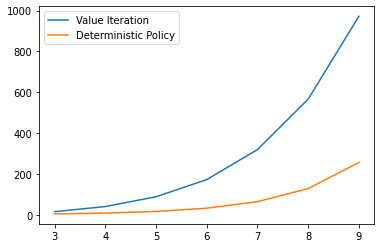

In [28]:
import matplotlib.pyplot as plt
x_ = np.arange(3, 10, 1)
plt.plot(x_,num_it,label="Value Iteration")
plt.legend()
plt.plot(x_,num_det,label="Deterministic Policy")
plt.legend()

### Job-Hopping and Wages-Utility-Maximization

The state space $\mathcal S = \{E, U\} \times \{i \ | \ 0\leqslant i \leqslant  n\}$, where $E$ stands for employed and $U$ stands for unemployed, and $i$ is the index of the job.

We can accept or decline a job only when unemployed. When we're employed, we can only continue with the job. So we can denote the action space as $\mathcal A((i,E)) = \{A\}$ and $\mathcal A((i,U))=\{A,D\}$, where $A$ stands for accepting the job and $U$ stands for declining the job.

The state transition probabilities  
$Pr[(i',E) | (i,E),A] = 1-\alpha $ for $i'=i$  
$Pr[(i',E) | (i,U),A] = 1-\alpha $ for $i'=i$  
$Pr[(i',U) | (i,U),A] = \alpha \cdot p_{i'} $ for $1\leqslant i' \leqslant n$  
$Pr[(i',U) | (i,E),A] = \alpha \cdot p_{i'} $ for $1\leqslant i' \leqslant n$  
$Pr[(i',U) | (i,U),D] = p_{i'} $  
$Pr[(\cdot,\cdot) | (\cdot, \cdot), \cdot] = 0$ Otherwise

The reward functions  
$R((i,E),A) = U(w_{i})$ for $1 \leqslant i \leqslant n$  
$R((i,U),A) = U(w_{i})$ for $1 \leqslant i \leqslant n$  
$R((i,U),D) = U(w_{0})$ for $1 \leqslant i \leqslant n$
